In [340]:
import numpy as np
import json
import torch.nn as nn
import torch
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn import svm
from tqdm import tqdm
import random

from math import sqrt
from math import exp
from math import pi


In [2]:
with open('./g2st.txt') as f:
    data = [l for l in f.readlines()]

In [3]:
datapoints = [point.split(':') for point in data]

In [187]:
labels_data = [int(point[0]) for point in datapoints]
input_long = [json.loads(point[3]) for point in datapoints]
input_short = [json.loads(point[1]) for point in datapoints]

In [290]:
test_pd = pd.DataFrame(input_short)
long_test_pd = pd.DataFrame(input_long)

In [ ]:
# long input does not have any NaN
# short input has some NaN in the last column

In [111]:
labels

tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1], device='cuda:0')

## data preprocessing

In [285]:
#np.count_nonzero(test_pd.isna()[6])
test_pd[6] = test_pd[6].fillna(0)
# normalized_test_pd = preprocessing.normalize(test_pd)
# normalized_test_pd = pd.DataFrame(normalized_test_pd, columns=test_pd.columns)
normalized_test_pd = preprocessing.normalize(long_test_pd)
normalized_test_pd = pd.DataFrame(normalized_test_pd, columns=long_test_pd.columns)


In [309]:
#X = normalized_test_pd.to_numpy()
test_pd[6] = test_pd[6].fillna(0)

X = long_test_pd.to_numpy()

In [211]:
# hist_data_large = preprocessing.normalize(hist_data_large)
# X = hist_data_large

normalized_test_pd_small = preprocessing.normalize(test_pd)
normalized_test_pd_small = pd.DataFrame(normalized_test_pd, columns=test_pd.columns)
frames = [normalized_test_pd_small, normalized_test_pd]
combined_data = pd.concat(frames,axis=1)
X = combined_data.to_numpy()

In [223]:
X = normalized_test_pd_small.to_numpy()

In [310]:
X_train, X_test, y_train, y_test = train_test_split(X, labels_data, test_size=0.2)

In [216]:
class PolynomialDataset(Dataset):
    def __init__(self, X, Y):
        self.input_data = X
        self.labels = Y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_data[idx], self.labels[idx]

In [225]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
train_dataset = PolynomialDataset(X_train, y_train)
test_dataset = PolynomialDataset(X_test, y_test)

In [226]:
X_train.shape

(800000, 7)

In [219]:
batch_size = 50
n_iters = 160000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [229]:
# class FeedforwardNeuralNetModel(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(FeedforwardNeuralNetModel, self).__init__()
        
#         self.fc1 = nn.Linear(input_dim, hidden_dim) 
#         self.sigmoid = nn.Sigmoid()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)  

#     def forward(self, x):
#         out = self.fc1(x)
#         out = self.sigmoid(out)
#         out = self.fc2(out)
#         return out
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
        
        
        # Define batch norm
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        out = self.fc1(x)
        #out = self.dropout(out)
        #out = self.batch_norm(out)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.dropout(out)
        #out = self.batch_norm(out)
        out = self.relu2(out)
        out = self.fc3(out)
        #out = self.dropout(out)
        #out = self.batch_norm(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out
    
# class RNN(nn.Module):
#     def __init__(self, batch_size, n_inputs, n_neurons):
#         super(RNN, self).__init__()
        
#         self.rnn = nn.RNNCell(n_inputs, n_neurons)
#         self.hx = torch.randn(batch_size, n_neurons) # initialize hidden state
        
#     def forward(self, X):
#         output = []

#         # for each time step
#         for i in range(2):
#             self.hx = self.rnn(X[i], self.hx)
#             output.append(self.hx)
        
#         return output, self.hx

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)
    
    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1)
        hidden = torch.sigmoid(self.in2hidden(combined))
        output = self.in2output(combined)
        return output, hidden
    
    def init_hidden(self):
        return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))


class CovNet(nn.Module):   
    def __init__(self):
        super(CovNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(4 * 7 * 7, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    

In [220]:
input_dim = 107
hidden_dim = 200
output_dim = 2

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()

In [276]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


In [221]:
model = model.to(device)

In [222]:
iter = 0

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = torch.tensor(inputs).requires_grad_()
        inputs = inputs.to(device)
        # Load images with gradient accumulation capabilities
        #images = images.view(-1, 28*28).requires_grad_()
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(inputs)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, labels in test_loader:
                inputs = torch.tensor(inputs).requires_grad_()
                inputs = inputs.to(device)
                # Load images with gradient accumulation capabilities
                #images = images.view(-1, 28*28).requires_grad_()
                labels = labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(inputs)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * float(correct) / float(total)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))


/scratch2/hle/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/scratch2/hle/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 500. Loss: 0.691423773765564. Accuracy: 54.737
Iteration: 1000. Loss: 0.6857364773750305. Accuracy: 60.8505
Iteration: 1500. Loss: 0.6352726221084595. Accuracy: 64.1545
Iteration: 2000. Loss: 0.5814011096954346. Accuracy: 67.3205
Iteration: 2500. Loss: 0.6371244192123413. Accuracy: 67.408
Iteration: 3000. Loss: 0.5633236765861511. Accuracy: 67.3135
Iteration: 3500. Loss: 0.6698815822601318. Accuracy: 67.702
Iteration: 4000. Loss: 0.5103259086608887. Accuracy: 67.8145
Iteration: 4500. Loss: 0.6399386525154114. Accuracy: 67.7375
Iteration: 5000. Loss: 0.5155748128890991. Accuracy: 68.59
Iteration: 5500. Loss: 0.5165994167327881. Accuracy: 68.555
Iteration: 6000. Loss: 0.5869423151016235. Accuracy: 68.7175
Iteration: 6500. Loss: 0.5686057806015015. Accuracy: 68.926
Iteration: 7000. Loss: 0.5001527667045593. Accuracy: 68.1505
Iteration: 7500. Loss: 0.47263866662979126. Accuracy: 69.421
Iteration: 8000. Loss: 0.43666785955429077. Accuracy: 68.5475
Iteration: 8500. Loss: 0.5855559

Iteration: 67500. Loss: 0.38506218791007996. Accuracy: 77.0445
Iteration: 68000. Loss: 0.33549731969833374. Accuracy: 76.1735
Iteration: 68500. Loss: 0.37750375270843506. Accuracy: 77.291
Iteration: 69000. Loss: 0.42843401432037354. Accuracy: 77.182
Iteration: 69500. Loss: 0.41337716579437256. Accuracy: 76.908
Iteration: 70000. Loss: 0.42174607515335083. Accuracy: 77.251
Iteration: 70500. Loss: 0.4030623733997345. Accuracy: 77.2925
Iteration: 71000. Loss: 0.4535084664821625. Accuracy: 77.236
Iteration: 71500. Loss: 0.41013476252555847. Accuracy: 77.4695
Iteration: 72000. Loss: 0.46011218428611755. Accuracy: 76.462
Iteration: 72500. Loss: 0.3696901202201843. Accuracy: 76.613
Iteration: 73000. Loss: 0.42884305119514465. Accuracy: 77.552
Iteration: 73500. Loss: 0.4614757299423218. Accuracy: 77.4305
Iteration: 74000. Loss: 0.3395008444786072. Accuracy: 77.0865
Iteration: 74500. Loss: 0.33523574471473694. Accuracy: 77.6105
Iteration: 75000. Loss: 0.3789323568344116. Accuracy: 77.431
Iterati

Iteration: 133500. Loss: 0.42356419563293457. Accuracy: 78.117
Iteration: 134000. Loss: 0.5119556188583374. Accuracy: 78.7765
Iteration: 134500. Loss: 0.43109214305877686. Accuracy: 78.662
Iteration: 135000. Loss: 0.3544517159461975. Accuracy: 78.7225
Iteration: 135500. Loss: 0.31886863708496094. Accuracy: 78.6725
Iteration: 136000. Loss: 0.5705563426017761. Accuracy: 78.5495
Iteration: 136500. Loss: 0.3238692581653595. Accuracy: 78.6735
Iteration: 137000. Loss: 0.5666868090629578. Accuracy: 78.6235
Iteration: 137500. Loss: 0.4550609588623047. Accuracy: 78.0205
Iteration: 138000. Loss: 0.2299964874982834. Accuracy: 78.5805
Iteration: 138500. Loss: 0.3684117794036865. Accuracy: 78.6675
Iteration: 139000. Loss: 0.4715268611907959. Accuracy: 78.609
Iteration: 139500. Loss: 0.4127715826034546. Accuracy: 78.722
Iteration: 140000. Loss: 0.4094434380531311. Accuracy: 78.486
Iteration: 140500. Loss: 0.3832798898220062. Accuracy: 78.8095
Iteration: 141000. Loss: 0.4863744080066681. Accuracy: 78

In [ ]:
# 1 hidden layer 50 unit, sigmoid act 
#Iteration: 82000. Loss: 0.5352512001991272. Accuracy: 68.227
# 3 hidden layer 100 unit, sigmoid act 
#Iteration: 82500. Loss: 0.4631064236164093. Accuracy: 79.512

### RNN

In [246]:
hidden_size = 100
learning_rate = 0.01

model = RNN(1, hidden_size, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [247]:
train_dataset[0]

(array([-0.14166613,  0.07981981,  0.        ,  0.08785756,  0.07682925,
         0.121122  ,  0.13210426], dtype=float32), 1)

In [250]:
num_epochs = 10
print_interval = 5000

for epoch in range(num_epochs):
    #random.shuffle(train_dataset)
    for i, (inputs, label) in enumerate(train_dataset):
        hidden_state = model.init_hidden()
        label = torch.tensor([label])
        for coeff in inputs:
            coeff = torch.Tensor([[coeff]])
#             print(type(hidden_state))
#             print(hidden_state)
#             print('####')
#             print(torch.cat((coeff, hidden_state),1))
            output, hidden_state = model(coeff, hidden_state)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )


Epoch [1/10], Step [5000/800000], Loss: 0.6329
Epoch [1/10], Step [10000/800000], Loss: 0.6487
Epoch [1/10], Step [15000/800000], Loss: 0.7472
Epoch [1/10], Step [20000/800000], Loss: 0.8218
Epoch [1/10], Step [25000/800000], Loss: 0.7266
Epoch [1/10], Step [30000/800000], Loss: 0.6513
Epoch [1/10], Step [35000/800000], Loss: 0.6752
Epoch [1/10], Step [40000/800000], Loss: 0.8303
Epoch [1/10], Step [45000/800000], Loss: 0.6324
Epoch [1/10], Step [50000/800000], Loss: 0.6298
Epoch [1/10], Step [55000/800000], Loss: 0.7727
Epoch [1/10], Step [60000/800000], Loss: 0.5949
Epoch [1/10], Step [65000/800000], Loss: 0.6619
Epoch [1/10], Step [70000/800000], Loss: 0.7425
Epoch [1/10], Step [75000/800000], Loss: 0.9420
Epoch [1/10], Step [80000/800000], Loss: 0.8581
Epoch [1/10], Step [85000/800000], Loss: 0.4874
Epoch [1/10], Step [90000/800000], Loss: 0.7714
Epoch [1/10], Step [95000/800000], Loss: 0.6274
Epoch [1/10], Step [100000/800000], Loss: 0.6098
Epoch [1/10], Step [105000/800000], Loss

Epoch [2/10], Step [45000/800000], Loss: 0.8980
Epoch [2/10], Step [50000/800000], Loss: 0.1172
Epoch [2/10], Step [55000/800000], Loss: 0.6187
Epoch [2/10], Step [60000/800000], Loss: 0.6052
Epoch [2/10], Step [65000/800000], Loss: 0.6550
Epoch [2/10], Step [70000/800000], Loss: 0.8027
Epoch [2/10], Step [75000/800000], Loss: 0.7547
Epoch [2/10], Step [80000/800000], Loss: 0.8986
Epoch [2/10], Step [85000/800000], Loss: 0.2695
Epoch [2/10], Step [90000/800000], Loss: 1.5037
Epoch [2/10], Step [95000/800000], Loss: 0.6570
Epoch [2/10], Step [100000/800000], Loss: 1.3170
Epoch [2/10], Step [105000/800000], Loss: 1.3473
Epoch [2/10], Step [110000/800000], Loss: 0.6607
Epoch [2/10], Step [115000/800000], Loss: 1.0768
Epoch [2/10], Step [120000/800000], Loss: 0.4651
Epoch [2/10], Step [125000/800000], Loss: 0.6591
Epoch [2/10], Step [130000/800000], Loss: 0.4936
Epoch [2/10], Step [135000/800000], Loss: 0.6508
Epoch [2/10], Step [140000/800000], Loss: 0.4281
Epoch [2/10], Step [145000/8000

Epoch [3/10], Step [85000/800000], Loss: 0.1474
Epoch [3/10], Step [90000/800000], Loss: 0.7674
Epoch [3/10], Step [95000/800000], Loss: 0.4719
Epoch [3/10], Step [100000/800000], Loss: 0.5977
Epoch [3/10], Step [105000/800000], Loss: 0.2345
Epoch [3/10], Step [110000/800000], Loss: 0.4220
Epoch [3/10], Step [115000/800000], Loss: 0.8335
Epoch [3/10], Step [120000/800000], Loss: 0.3593
Epoch [3/10], Step [125000/800000], Loss: 0.6792
Epoch [3/10], Step [130000/800000], Loss: 0.5850
Epoch [3/10], Step [135000/800000], Loss: 0.5780
Epoch [3/10], Step [140000/800000], Loss: 0.3556
Epoch [3/10], Step [145000/800000], Loss: 0.5742
Epoch [3/10], Step [150000/800000], Loss: 0.7013
Epoch [3/10], Step [155000/800000], Loss: 0.3379
Epoch [3/10], Step [160000/800000], Loss: 0.6204
Epoch [3/10], Step [165000/800000], Loss: 0.8273
Epoch [3/10], Step [170000/800000], Loss: 0.1710
Epoch [3/10], Step [175000/800000], Loss: 0.5763
Epoch [3/10], Step [180000/800000], Loss: 1.7285
Epoch [3/10], Step [185

Epoch [4/10], Step [125000/800000], Loss: 0.8849
Epoch [4/10], Step [130000/800000], Loss: 0.2872
Epoch [4/10], Step [135000/800000], Loss: 0.3609
Epoch [4/10], Step [140000/800000], Loss: 0.5454
Epoch [4/10], Step [145000/800000], Loss: 0.4992
Epoch [4/10], Step [150000/800000], Loss: 0.8926
Epoch [4/10], Step [155000/800000], Loss: 0.4288
Epoch [4/10], Step [160000/800000], Loss: 1.0726
Epoch [4/10], Step [165000/800000], Loss: 0.9524
Epoch [4/10], Step [170000/800000], Loss: 0.4012
Epoch [4/10], Step [175000/800000], Loss: 1.7717
Epoch [4/10], Step [180000/800000], Loss: 1.6723
Epoch [4/10], Step [185000/800000], Loss: 0.4828
Epoch [4/10], Step [190000/800000], Loss: 0.5812
Epoch [4/10], Step [195000/800000], Loss: 0.6662
Epoch [4/10], Step [200000/800000], Loss: 0.7631
Epoch [4/10], Step [205000/800000], Loss: 0.6789
Epoch [4/10], Step [210000/800000], Loss: 1.3662
Epoch [4/10], Step [215000/800000], Loss: 0.1320
Epoch [4/10], Step [220000/800000], Loss: 1.1024
Epoch [4/10], Step [

Epoch [5/10], Step [165000/800000], Loss: 0.7462
Epoch [5/10], Step [170000/800000], Loss: 0.2074
Epoch [5/10], Step [175000/800000], Loss: 0.9839
Epoch [5/10], Step [180000/800000], Loss: 1.7769
Epoch [5/10], Step [185000/800000], Loss: 0.6502
Epoch [5/10], Step [190000/800000], Loss: 0.5439
Epoch [5/10], Step [195000/800000], Loss: 1.2408
Epoch [5/10], Step [200000/800000], Loss: 0.5064
Epoch [5/10], Step [205000/800000], Loss: 1.0898
Epoch [5/10], Step [210000/800000], Loss: 1.2199
Epoch [5/10], Step [215000/800000], Loss: 0.1971
Epoch [5/10], Step [220000/800000], Loss: 0.0046
Epoch [5/10], Step [225000/800000], Loss: 0.6198
Epoch [5/10], Step [230000/800000], Loss: 1.6649
Epoch [5/10], Step [235000/800000], Loss: 1.1510
Epoch [5/10], Step [240000/800000], Loss: 0.9598
Epoch [5/10], Step [245000/800000], Loss: 1.2943
Epoch [5/10], Step [250000/800000], Loss: 0.9154
Epoch [5/10], Step [255000/800000], Loss: 1.5134
Epoch [5/10], Step [260000/800000], Loss: 1.8769
Epoch [5/10], Step [

Epoch [6/10], Step [205000/800000], Loss: 0.7897
Epoch [6/10], Step [210000/800000], Loss: 0.5303
Epoch [6/10], Step [215000/800000], Loss: 0.2092
Epoch [6/10], Step [220000/800000], Loss: 0.0740
Epoch [6/10], Step [225000/800000], Loss: 1.4213
Epoch [6/10], Step [230000/800000], Loss: 2.7253
Epoch [6/10], Step [235000/800000], Loss: 0.5462
Epoch [6/10], Step [240000/800000], Loss: 0.7052
Epoch [6/10], Step [245000/800000], Loss: 0.8615
Epoch [6/10], Step [250000/800000], Loss: 1.3473
Epoch [6/10], Step [255000/800000], Loss: 1.8966
Epoch [6/10], Step [260000/800000], Loss: 0.2072
Epoch [6/10], Step [265000/800000], Loss: 0.3995
Epoch [6/10], Step [270000/800000], Loss: 0.4670
Epoch [6/10], Step [275000/800000], Loss: 0.6554
Epoch [6/10], Step [280000/800000], Loss: 0.7876
Epoch [6/10], Step [285000/800000], Loss: 0.8267
Epoch [6/10], Step [290000/800000], Loss: 0.5326
Epoch [6/10], Step [295000/800000], Loss: 0.2622
Epoch [6/10], Step [300000/800000], Loss: 0.6994
Epoch [6/10], Step [

Epoch [7/10], Step [245000/800000], Loss: 0.9024
Epoch [7/10], Step [250000/800000], Loss: 0.8084
Epoch [7/10], Step [255000/800000], Loss: 1.8044
Epoch [7/10], Step [260000/800000], Loss: 0.5607
Epoch [7/10], Step [265000/800000], Loss: 0.4089
Epoch [7/10], Step [270000/800000], Loss: 0.8777
Epoch [7/10], Step [275000/800000], Loss: 0.8606
Epoch [7/10], Step [280000/800000], Loss: 0.5404
Epoch [7/10], Step [285000/800000], Loss: 0.7792
Epoch [7/10], Step [290000/800000], Loss: 0.6660
Epoch [7/10], Step [295000/800000], Loss: 0.5221
Epoch [7/10], Step [300000/800000], Loss: 1.0045
Epoch [7/10], Step [305000/800000], Loss: 0.6359
Epoch [7/10], Step [310000/800000], Loss: 0.3895
Epoch [7/10], Step [315000/800000], Loss: 0.7984
Epoch [7/10], Step [320000/800000], Loss: 0.6166
Epoch [7/10], Step [325000/800000], Loss: 1.5890
Epoch [7/10], Step [330000/800000], Loss: 0.8052
Epoch [7/10], Step [335000/800000], Loss: 1.2217
Epoch [7/10], Step [340000/800000], Loss: 0.6069
Epoch [7/10], Step [

Epoch [8/10], Step [285000/800000], Loss: 0.7108
Epoch [8/10], Step [290000/800000], Loss: 0.2625
Epoch [8/10], Step [295000/800000], Loss: 0.2352
Epoch [8/10], Step [300000/800000], Loss: 0.7551
Epoch [8/10], Step [305000/800000], Loss: 1.1831
Epoch [8/10], Step [310000/800000], Loss: 0.2664
Epoch [8/10], Step [315000/800000], Loss: 0.5826
Epoch [8/10], Step [320000/800000], Loss: 0.5966
Epoch [8/10], Step [325000/800000], Loss: 0.4195
Epoch [8/10], Step [330000/800000], Loss: 1.0917
Epoch [8/10], Step [335000/800000], Loss: 0.9955
Epoch [8/10], Step [340000/800000], Loss: 0.3219
Epoch [8/10], Step [345000/800000], Loss: 0.5765
Epoch [8/10], Step [350000/800000], Loss: 0.6131
Epoch [8/10], Step [355000/800000], Loss: 0.4231
Epoch [8/10], Step [360000/800000], Loss: 0.2741
Epoch [8/10], Step [365000/800000], Loss: 0.4995
Epoch [8/10], Step [370000/800000], Loss: 0.5175
Epoch [8/10], Step [375000/800000], Loss: 0.4212
Epoch [8/10], Step [380000/800000], Loss: 0.7276
Epoch [8/10], Step [

Epoch [9/10], Step [325000/800000], Loss: 1.9356
Epoch [9/10], Step [330000/800000], Loss: 0.2724
Epoch [9/10], Step [335000/800000], Loss: 0.8248
Epoch [9/10], Step [340000/800000], Loss: 0.3136
Epoch [9/10], Step [345000/800000], Loss: 0.5346
Epoch [9/10], Step [350000/800000], Loss: 0.6270
Epoch [9/10], Step [355000/800000], Loss: 0.6123
Epoch [9/10], Step [360000/800000], Loss: 0.5238
Epoch [9/10], Step [365000/800000], Loss: 0.5681
Epoch [9/10], Step [370000/800000], Loss: 0.4750
Epoch [9/10], Step [375000/800000], Loss: 0.1480
Epoch [9/10], Step [380000/800000], Loss: 0.6361
Epoch [9/10], Step [385000/800000], Loss: 0.3618
Epoch [9/10], Step [390000/800000], Loss: 1.5310
Epoch [9/10], Step [395000/800000], Loss: 0.7351
Epoch [9/10], Step [400000/800000], Loss: 0.2604
Epoch [9/10], Step [405000/800000], Loss: 0.7971
Epoch [9/10], Step [410000/800000], Loss: 0.9702
Epoch [9/10], Step [415000/800000], Loss: 0.7821
Epoch [9/10], Step [420000/800000], Loss: 0.4988
Epoch [9/10], Step [

Epoch [10/10], Step [360000/800000], Loss: 0.4704
Epoch [10/10], Step [365000/800000], Loss: 0.5698
Epoch [10/10], Step [370000/800000], Loss: 0.3799
Epoch [10/10], Step [375000/800000], Loss: 0.5221
Epoch [10/10], Step [380000/800000], Loss: 2.0788
Epoch [10/10], Step [385000/800000], Loss: 0.5488
Epoch [10/10], Step [390000/800000], Loss: 0.8392
Epoch [10/10], Step [395000/800000], Loss: 0.6325
Epoch [10/10], Step [400000/800000], Loss: 0.3038
Epoch [10/10], Step [405000/800000], Loss: 0.5114
Epoch [10/10], Step [410000/800000], Loss: 0.7879
Epoch [10/10], Step [415000/800000], Loss: 0.7201
Epoch [10/10], Step [420000/800000], Loss: 3.5857
Epoch [10/10], Step [425000/800000], Loss: 0.7996
Epoch [10/10], Step [430000/800000], Loss: 2.0716
Epoch [10/10], Step [435000/800000], Loss: 0.6943
Epoch [10/10], Step [440000/800000], Loss: 0.3130
Epoch [10/10], Step [445000/800000], Loss: 0.7865
Epoch [10/10], Step [450000/800000], Loss: 0.2051
Epoch [10/10], Step [455000/800000], Loss: 0.8318


In [252]:
num_correct = 0
num_samples = len(test_dataset)

model.eval()

with torch.no_grad():
    for name, label in test_dataset:
        hidden_state = model.init_hidden()
        for char in name:
            coeff = torch.Tensor([[char]])
            output, hidden_state = model(coeff, hidden_state)
        _, pred = torch.max(output, dim=1)
        num_correct += bool(pred == label)

print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")


Accuracy: 53.7410%


In [109]:
## CovNet


# defining the model
covModel = CovNet()
# defining the optimizer
optimizer = torch.optim.Adam(covModel.parameters(), lr=0.07)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=7, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=2, bias=True)
  (batch_norm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [127]:

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = torch.autograd.Variable(train_x), torch.autograd.Variable(train_y)
    # getting the validation set
    x_val, y_val = torch.autograd.Variable(val_x), torch.autograd.Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [128]:
train_x = torch.from_numpy(X_train)
train_y = torch.from_numpy(np.array(y_train))
val_x = torch.from_numpy(X_test)
val_y = torch.from_numpy(np.array(y_test))
# defining the number of epochs
n_epochs = 10
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

RuntimeError: mat1 dim 1 must match mat2 dim 0

## SVM

In [95]:
clf = svm.SVC(kernel='rbf')


In [96]:
chunk_X = X_train[:100000,:]
chunk_Y = y_train[:100000]

In [97]:
#Train the model using the training sets
clf.fit(chunk_X, chunk_Y)

SVC()

In [99]:
X_test_chunk = X_test[:40000,:]
y_pred = clf.predict(X_test_chunk)


In [83]:
len(y_test)

200000

In [100]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test[:40000], y_pred))


Accuracy: 0.723625


In [ ]:
## SVM rbf kernel:
##### training data 100k -> acc: 72.3625%
## SVM poly kernel, degree = 7: 
##### training data 40k -> acc: 75.5%
##### training data 60k -> acc: 77.6225%

In [142]:
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT-custom")

model = AutoModelForMaskedLM.from_pretrained("tbs17/MathBERT-custom")

Some weights of the model checkpoint at tbs17/MathBERT-custom were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [129]:
#train model taking both inputs 
#combine short AND long.
#histogram of data as input
# polynomial SVM

In [133]:
d = np.random.laplace(loc=15, scale=3, size=500)

In [155]:

hist, bin_edges = np.histogram(long_test_pd.iloc[0])

In [151]:
#min(long_test_pd.iloc[0])
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

long_test_pd.apply(minMax)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
min,-3.670652,-3.670652,-3.713907,-3.753259,-3.753259,-3.753259,-3.753259,-3.846096,-3.846096,-3.846096,...,-3.987661,-3.939421,-3.955389,-3.955389,-3.955389,-3.955389,-3.955389,-3.955389,-3.962344,-3.962344
max,3.670652,3.670652,3.713907,3.753259,3.753259,3.753259,3.753259,3.753259,3.846096,3.846096,...,3.987661,3.939421,3.942972,3.942972,3.955389,3.955389,3.955389,3.955389,3.933636,3.962344


In [173]:
hist_data_large = []
for i in tqdm(range(1000000)):
    hist, bin_edges = np.histogram(long_test_pd.iloc[i])
    hist_data_large.append(hist)

100%|██████████| 1000000/1000000 [03:43<00:00, 4482.49it/s]


In [169]:
for i in hist_data_large:
    if len(i) != 10:
        print(i)

(0.0, 30.0)

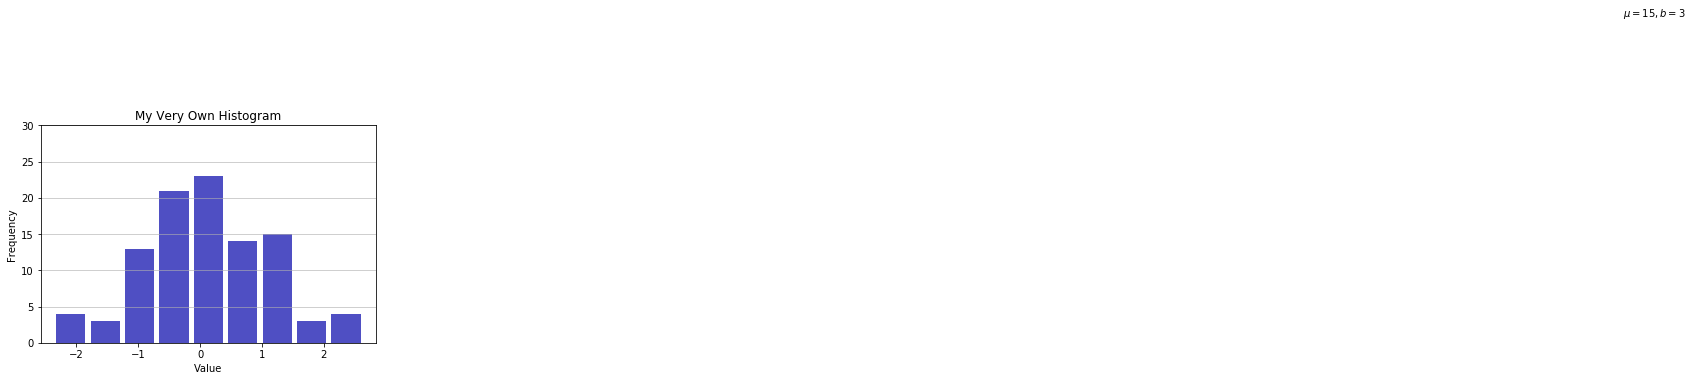

In [160]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=long_test_pd.iloc[0], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


In [349]:
with open('./g2st2.txt') as f:
    data = [l for l in f.readlines()]

In [350]:
datapoints = [point.split(':') for point in data]
labels_data = [(ord(point[0]) - ord('A')) for point in datapoints]
input_long = [json.loads(point[4]) for point in datapoints]
input_short = [json.loads(point[2]) for point in datapoints]

In [268]:
test_pd[6] = test_pd[6].fillna(0)
# normalized_test_pd = preprocessing.normalize(test_pd)
# normalized_test_pd = pd.DataFrame(normalized_test_pd, columns=test_pd.columns)
normalized_test_pd = preprocessing.normalize(test_pd)
normalized_test_pd = pd.DataFrame(normalized_test_pd, columns=test_pd.columns)
X = normalized_test_pd.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, labels_data, test_size=0.2)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
train_dataset = PolynomialDataset(X_train, y_train)
test_dataset = PolynomialDataset(X_test, y_test)
batch_size = 50
n_iters = 160000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [277]:
input_dim = 7
hidden_dim = 100
output_dim = len(set(y_train))

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
learning_rate = 0.2

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()
model = model.to(device)

iter = 0

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = torch.tensor(inputs).requires_grad_()
        inputs = inputs.to(device)
        # Load images with gradient accumulation capabilities
        #images = images.view(-1, 28*28).requires_grad_()
        labels = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(inputs)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for inputs, labels in test_loader:
                inputs = torch.tensor(inputs).requires_grad_()
                inputs = inputs.to(device)
                # Load images with gradient accumulation capabilities
                #images = images.view(-1, 28*28).requires_grad_()
                labels = labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(inputs)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * float(correct) / float(total)

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

/scratch2/hle/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/scratch2/hle/py3_env/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 500. Loss: 0.7957994341850281. Accuracy: 49.9715
Iteration: 1000. Loss: 0.9078439474105835. Accuracy: 46.905
Iteration: 1500. Loss: 0.7555695176124573. Accuracy: 46.905
Iteration: 2000. Loss: 0.8731020092964172. Accuracy: 49.9715
Iteration: 2500. Loss: 0.7843074202537537. Accuracy: 49.9715
Iteration: 3000. Loss: 0.7954131960868835. Accuracy: 49.9715
Iteration: 3500. Loss: 0.843656599521637. Accuracy: 46.905
Iteration: 4000. Loss: 0.8131417036056519. Accuracy: 49.9715
Iteration: 4500. Loss: 0.8284525275230408. Accuracy: 49.9715
Iteration: 5000. Loss: 0.8486237525939941. Accuracy: 49.9695
Iteration: 5500. Loss: 1.0566089153289795. Accuracy: 49.9715
Iteration: 6000. Loss: 0.820784330368042. Accuracy: 49.9715
Iteration: 6500. Loss: 0.7080662250518799. Accuracy: 49.9715
Iteration: 7000. Loss: 0.9724759459495544. Accuracy: 49.8615
Iteration: 7500. Loss: 0.7862006425857544. Accuracy: 49.9715
Iteration: 8000. Loss: 0.8680818676948547. Accuracy: 49.9715
Iteration: 8500. Loss: 0.78067

Iteration: 67500. Loss: 0.7801868319511414. Accuracy: 49.9715
Iteration: 68000. Loss: 0.7866240739822388. Accuracy: 49.9715
Iteration: 68500. Loss: 0.9021982550621033. Accuracy: 49.9715
Iteration: 69000. Loss: 0.9380286931991577. Accuracy: 49.9715
Iteration: 69500. Loss: 0.7183753848075867. Accuracy: 49.9715
Iteration: 70000. Loss: 0.9590854048728943. Accuracy: 46.905
Iteration: 70500. Loss: 0.7295603156089783. Accuracy: 49.9715
Iteration: 71000. Loss: 0.7778328657150269. Accuracy: 46.905
Iteration: 71500. Loss: 0.8106796741485596. Accuracy: 49.9715
Iteration: 72000. Loss: 0.7850358486175537. Accuracy: 46.905
Iteration: 72500. Loss: 0.8471395373344421. Accuracy: 49.9715
Iteration: 73000. Loss: 0.9037904143333435. Accuracy: 49.9715
Iteration: 73500. Loss: 0.7847880721092224. Accuracy: 49.9715
Iteration: 74000. Loss: 0.9342987537384033. Accuracy: 49.9715
Iteration: 74500. Loss: 0.9613833427429199. Accuracy: 49.9625
Iteration: 75000. Loss: 0.7769737839698792. Accuracy: 49.9715
Iteration: 

Iteration: 133500. Loss: 0.8659034967422485. Accuracy: 49.9715
Iteration: 134000. Loss: 0.7837755084037781. Accuracy: 46.976
Iteration: 134500. Loss: 0.7911128997802734. Accuracy: 49.9715
Iteration: 135000. Loss: 0.7808331847190857. Accuracy: 49.9715
Iteration: 135500. Loss: 0.8160150647163391. Accuracy: 49.9715
Iteration: 136000. Loss: 0.7839273810386658. Accuracy: 49.9715
Iteration: 136500. Loss: 0.8397297859191895. Accuracy: 49.9715
Iteration: 137000. Loss: 0.8941104412078857. Accuracy: 49.9715
Iteration: 137500. Loss: 0.8747947812080383. Accuracy: 49.9715
Iteration: 138000. Loss: 0.7625395059585571. Accuracy: 49.9715
Iteration: 138500. Loss: 0.8950851559638977. Accuracy: 49.9715
Iteration: 139000. Loss: 0.7295624613761902. Accuracy: 49.9715
Iteration: 139500. Loss: 0.9674691557884216. Accuracy: 49.9715
Iteration: 140000. Loss: 0.7163895964622498. Accuracy: 49.9715
Iteration: 140500. Loss: 0.8740801811218262. Accuracy: 49.977
Iteration: 141000. Loss: 0.7193737030029297. Accuracy: 49

In [355]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))
#Number of mislabeled points out of a total 75 points : 4

Number of mislabeled points out of a total 200000 points : 7473


In [354]:
X_train, X_test, y_train, y_test = train_test_split(input_long, labels_data, test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [358]:
#binary class acc 1 - 7674/200000 = 0.96163
# mult class acc 1- 7473/200000 = 0.962635

In [342]:
# Naive Bayes Algorithm
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = list()
    for row in test:
        output = predict(summarize, row)
        predictions.append(output)
    return(predictions)
def summarize_by_class(dataset):
    separated = separate_by_class(dataset)
    summaries = dict()
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    return summaries

def separate_by_class(dataset):
    separated = dict()
    for i in range(len(dataset)):
        vector = dataset[i]
        class_value = vector[-1]
        if (class_value not in separated):
            separated[class_value] = list()
        separated[class_value].append(vector)
    return separated


# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):
            mean, stdev, _ = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities

# Predict the class for a given row
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label

def summarize_dataset(dataset):
    summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
    del(summaries[-1])
    return summaries

def mean(numbers):
    return sum(numbers)/float(len(numbers))

def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [338]:
t = np.concatenate([X_train, np.array([y_train]).reshape(X_train.shape[0],1)],axis=1)
v = np.concatenate([X_test, np.array([y_test]).reshape(X_test.shape[0],1)],axis=1)

In [341]:
predicted = naive_bayes(t, v)



In [345]:
accuracy_metric(y_test, predicted)

96.1875

In [346]:
1-0.03837


0.96163

## Workflow

- Multilayer perceptron approach
    - clean up data
    - normalize
    - build model
- SVM approach
- naive bayes approach
    - build naive bayes